In [1]:
import pandas as pd
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel

from pathlib import Path
from tqdm import tqdm
from config import param_boost
pd.set_option('display.max_columns', None)

In [2]:
path = '../../prepare_data/data/df_general.csv'

df = pd.read_csv(Path(path).resolve())
y = df['team_1_hue']

df.drop(['team_1_hue', 'match_id'], axis=1, inplace=True)

In [3]:
df

gameweek_gameweek  gameweek_compSeason_label    teams_team_1_name  \
0                     1                       2014              Arsenal   
1                     1                       2014       Leicester City   
2                     1                       2014    Manchester United   
3                     1                       2014  Queens Park Rangers   
4                     1                       2014           Stoke City   
...                 ...                        ...                  ...   
3795                 38                       2023       Crystal Palace   
3796                 38                       2023            Liverpool   
3797                 38                       2023           Luton Town   
3798                 38                       2023      Manchester City   
3799                 38                       2023     Sheffield United   

            teams_team_2_name month day_week  hour  ground_id  \
0              Crystal Palace   Aug      Sat    17         52   
1                     Everton   Aug      Sat    15         49   
2                Swansea City   Aug      Sat    12         42   
3                   Hull City   Aug      Sat    15         46   
4                 Aston Villa   Aug      Sat    15        435   
...                       ...   ...      ...   ...        ...   
3795              Aston Villa   May      Sun    16         45   
3796  Wolverhampton Wanderers   May      Sun    16       7305   
3797                   Fulham   May      Sun    16       2025   
3798          West Ham United   May      Sun    16        457   
3799        Tottenham Hotspur   May      Sun    16       2003   

      _accurate_back_zone_pass_team_1  _accurate_chipped_pass_team_1  \
0                         7925.444444                     693.777778   
1                         6395.666667                     663.222222   
2                         7671.666667                     724.222222   
3                         4135.000000                     574.000000   
4                         5308.250000                     590.500000   
...                               ...                            ...   
3795                      5503.111111                     538.000000   
3796                      8856.333333                     844.333333   
3797                              NaN                            NaN   
3798                      9053.555556                     732.666667   
3799                      4923.500000                     555.500000   

      _accurate_corners_intobox_team_1  _accurate_cross_team_1  \
0                            51.222222              150.333333   
1                            46.666667              146.777778   
2                            49.000000              153.444444   
3                            67.000000              182.000000   
4                            53.000000              157.750000   
...                                ...                     ...   
3795                         55.666667              165.888889   
3796                         62.111111              180.222222   
3797                               NaN                     NaN   
3798                         72.555556              173.000000   
3799                         48.500000              161.500000   

      _accurate_cross_nocorner_team_1  _accurate_flick_on_team_1  \
0                          101.111111                  63.444444   
1                          102.777778                  99.222222   
2                          107.000000                  73.222222   
3                          116.000000                 137.000000   
4                          106.250000                 144.500000   
...                               ...                        ...   
3795                       111.333333                  91.333333   
3796                       119.888889                  63.222222   
3797                              NaN                 

In [4]:
#Признаки со смещением (лаги)
lag_features = [
            'result_lag_1_team_1',
            'result_lag_2_team_1',
            'result_lag_3_team_1',
            'result_lag_4_team_1',
            'result_lag_5_team_1',
            'result_lag_1_team_2',
            'result_lag_2_team_2',
            'result_lag_3_team_2',
            'result_lag_4_team_2',
            'result_lag_5_team_2',
            'game_lag_1',
            'game_lag_2',
            'game_lag_3'
            ]

In [5]:
cat_cols = [
            'gameweek_gameweek',
            'gameweek_compSeason_label',
            'ground_id',
           ]

In [6]:
cat_cols += df.describe(include='object').columns.to_list() + lag_features

In [7]:
df.loc[:, cat_cols]

,gameweek_gameweek,gameweek_compSeason_label,ground_id,teams_team_1_name,teams_team_2_name,month,day_week,F_0_name_team_1,F_1_name_team_1,F_2_name_team_1,M_0_name_team_1,M_1_name_team_1,M_2_name_team_1,M_3_name_team_1,M_4_name_team_1,M_5_name_team_1,D_0_name_team_1,D_1_name_team_1,D_2_name_team_1,D_3_name_team_1,D_4_name_team_1,D_5_name_team_1,D_6_name_team_1,GK_0_name_team_1,F_0_name_team_2,F_1_name_team_2,F_2_name_team_2,M_0_name_team_2,M_1_name_team_2,M_2_name_team_2,M_3_name_team_2,M_4_name_team_2,M_5_name_team_2,D_0_name_team_2,D_1_name_team_2,D_2_name_team_2,D_3_name_team_2,D_4_name_team_2,D_5_name_team_2,D_6_name_team_2,GK_0_name_team_2,result_lag_1_team_1,result_lag_2_team_1,result_lag_3_team_1,result_lag_4_team_1,result_lag_5_team_1,result_lag_1_team_2,result_lag_2_team_2,result_lag_3_team_2,result_lag_4_team_2,result_lag_5_team_2,game_lag_1,game_lag_2,game_lag_3
0,1,2014,52,Arsenal,Crystal Palace,Aug,Sat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014,49,Leicester City,Everton,Aug,Sat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014,42,Manchester United,Swansea City,Aug,Sat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2014,46,Queens Park Rangers,Hull City,Aug,Sat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2014,435,Stoke City,Aston Villa,Aug,Sat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,38,2023,45,Crystal Palace,Aston Villa,May,Sun,Jordan Ayew,Odsonne Édouard,Jean-Philippe Mateta,Eberechi Eze,Michael Olise,Jefferson Lerma,Jeffrey Schlupp,Cheick Doucouré,Will Hughes,Marc Guéhi,Tyrick Mitchell,Joachim Andersen,Joel Ward,Nathaniel Clyne,Chris Richards,James Tomkins,Dean Henderson,Ollie Watkins,Leon Bailey,Jhon Durán,Douglas Luiz,Jacob Ramsey,John McGinn,Youri Tielemans,Boubacar Kamara,Philippe Coutinho,Ezri Konsa,Tyrone Mings,Lucas Digne,Matty Cash,Clément Lenglet,Álex Moreno,Calum Chambers,Emiliano Martínez,1.0,1.0,2.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
3796,38,2023,7305,Liverpool,Wolverhampton Wanderers,May,Sun,Mohamed Salah,Darwin Núñez,Diogo Jota,Alexis Mac Allister,Alexis Mac Allister,Harvey Elliott,Thiago Alcântara,Curtis Jones,Stefan Bajcetic,Trent Alexander-Arnold,Andy Robertson,Virgil van Dijk,Joe Gomez,Kostas Tsimikas,Ibrahima Konaté,Joël Matip,Alisson Becker,Hwang Hee-Chan,Hwang Hee-Chan,Pedro Neto,Matheus Nunes,Mario Lemina,Pablo Sarabia,João Gomes,Boubacar Traoré,Tommy Doyle,Maximilian Kilman,Nélson Semedo,Rayan Aït-Nouri,Hugo Bueno,Jonny,Craig Dawson,Toti,José Sá,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0
3797,38,2023,2025,Luton Town,Fulham,May,Sun,Carlton Morris,Cauley Woodrow,Elijah Adebayo,Albert Sambi Lokonga,Albert Sambi Lokonga,Luke Berry,Pelly Ruddock Mpanzu,Jordan Clark,Fred Onyedinma,Tom Lockyer,Reece Burke,Amari'i Bell,Gabriel Osho,Joe Johnson,Mads Andersen,Issa Kaboré,James Shea,Alex Iwobi,Bobby De Cordova-Reid,Adama Traoré,Harrison Reed,João Palhinha,Tom Cairney,Andreas Pereira,Harry Wilson,Sasa Lukic,Timothy Castagne,Antonee Robinson,Tim Ream,Kenny Tete,Tosin Adarabioyo,Issa Diop,Calvin Bassey,Bernd Leno,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0

In [8]:
# Заменим наны на 999, для деревянных моделей это норм
df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(999)

In [9]:
df[lag_features] = df[lag_features].astype(int)

In [10]:
class_counts = np.bincount(y) #количество экземпляров каждого класса
total_samples = np.sum(class_counts) #общее количество экземпляров
class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
class_weights

array([1.05030404, 0.74160812, 1.42964635])

In [11]:
df

gameweek_gameweek  gameweek_compSeason_label    teams_team_1_name  \
0                     1                       2014              Arsenal   
1                     1                       2014       Leicester City   
2                     1                       2014    Manchester United   
3                     1                       2014  Queens Park Rangers   
4                     1                       2014           Stoke City   
...                 ...                        ...                  ...   
3795                 38                       2023       Crystal Palace   
3796                 38                       2023            Liverpool   
3797                 38                       2023           Luton Town   
3798                 38                       2023      Manchester City   
3799                 38                       2023     Sheffield United   

            teams_team_2_name month day_week  hour  ground_id  \
0              Crystal Palace   Aug      Sat    17         52   
1                     Everton   Aug      Sat    15         49   
2                Swansea City   Aug      Sat    12         42   
3                   Hull City   Aug      Sat    15         46   
4                 Aston Villa   Aug      Sat    15        435   
...                       ...   ...      ...   ...        ...   
3795              Aston Villa   May      Sun    16         45   
3796  Wolverhampton Wanderers   May      Sun    16       7305   
3797                   Fulham   May      Sun    16       2025   
3798          West Ham United   May      Sun    16        457   
3799        Tottenham Hotspur   May      Sun    16       2003   

      _accurate_back_zone_pass_team_1  _accurate_chipped_pass_team_1  \
0                         7925.444444                     693.777778   
1                         6395.666667                     663.222222   
2                         7671.666667                     724.222222   
3                         4135.000000                     574.000000   
4                         5308.250000                     590.500000   
...                               ...                            ...   
3795                      5503.111111                     538.000000   
3796                      8856.333333                     844.333333   
3797                              NaN                            NaN   
3798                      9053.555556                     732.666667   
3799                      4923.500000                     555.500000   

      _accurate_corners_intobox_team_1  _accurate_cross_team_1  \
0                            51.222222              150.333333   
1                            46.666667              146.777778   
2                            49.000000              153.444444   
3                            67.000000              182.000000   
4                            53.000000              157.750000   
...                                ...                     ...   
3795                         55.666667              165.888889   
3796                         62.111111              180.222222   
3797                               NaN                     NaN   
3798                         72.555556              173.000000   
3799                         48.500000              161.500000   

      _accurate_cross_nocorner_team_1  _accurate_flick_on_team_1  \
0                          101.111111                  63.444444   
1                          102.777778                  99.222222   
2                          107.000000                  73.222222   
3                          116.000000                 137.000000   
4                          106.250000                 144.500000   
...                               ...                        ...   
3795                       111.333333                  91.333333   
3796                       119.888889                  63.222222   
3797                              NaN                 

In [12]:
#Делаем кросс валидацию как в времянных рядах, 19 фолдов по 20 игр
preds, tests, proba = [], [], []
tscv = TimeSeriesSplit(n_splits=19, test_size=20)



for train_index, test_index in tscv.split(df, y):
    X_train = df.iloc[train_index]
    y_train = y.iloc[train_index]

    X_test = df.iloc[test_index]
    y_test = y.iloc[test_index]
   
    model = CatBoostClassifier(verbose=False, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols, plot=False)
    pred = model.predict(X_test)
    proba.extend(model.predict_proba(X_test))
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())
    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.47666666666666657
f1 score weighted: 0.44805194805194803
f1 score weighted: 0.519047619047619
f1 score weighted: 0.5130434782608695
f1 score weighted: 0.5046153846153846
f1 score weighted: 0.42036363636363633
f1 score weighted: 0.41692307692307695
f1 score weighted: 0.5666666666666667
f1 score weighted: 0.3247863247863248
f1 score weighted: 0.5769230769230769
f1 score weighted: 0.4782608695652174
f1 score weighted: 0.5333333333333333
f1 score weighted: 0.5333333333333333
f1 score weighted: 0.5039999999999999
f1 score weighted: 0.36703296703296706
f1 score weighted: 0.4708333333333333
f1 score weighted: 0.5354037267080745
f1 score weighted: 0.4488888888888889
f1 score weighted: 0.544927536231884


In [13]:
print(f"f1 score: {f1_score(tests, preds, average='weighted')}\naccuracy: {accuracy_score(tests, preds)}")

f1 score: 0.48036877624788454
accuracy: 0.5578947368421052


In [14]:
df.head()

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,month,day_week,hour,ground_id,_accurate_back_zone_pass_team_1,_accurate_chipped_pass_team_1,_accurate_corners_intobox_team_1,_accurate_cross_team_1,_accurate_cross_nocorner_team_1,_accurate_flick_on_team_1,_accurate_freekick_cross_team_1,_accurate_fwd_zone_pass_team_1,_accurate_goal_kicks_team_1,_accurate_keeper_sweeper_team_1,_accurate_keeper_throws_team_1,_accurate_launches_team_1,_accurate_layoffs_team_1,_accurate_long_balls_team_1,_accurate_pass_team_1,_accurate_pull_back_team_1,_accurate_through_ball_team_1,_accurate_throws_team_1,_aerial_lost_team_1,_aerial_won_team_1,_attempted_tackle_foul_team_1,_attempts_conceded_ibox_team_1,_attempts_conceded_obox_team_1,_attempts_ibox_team_1,_attempts_obox_team_1,_att_assist_openplay_team_1,_att_assist_setplay_team_1,_att_bx_centre_team_1,_att_bx_left_team_1,_att_bx_right_team_1,_att_cmiss_high_team_1,_att_cmiss_left_team_1,_att_cmiss_right_team_1,_att_corner_team_1,_att_fastbreak_team_1,_att_goal_high_centre_team_1,_att_goal_high_left_team_1,_att_goal_high_right_team_1,_att_goal_low_centre_team_1,_att_goal_low_left_team_1,_att_goal_low_right_team_1,_att_hd_goal_team_1,_att_hd_miss_team_1,_att_hd_post_team_1,_att_hd_target_team_1,_att_hd_total_team_1,_att_ibox_blocked_team_1,_att_ibox_goal_team_1,_att_ibox_miss_team_1,_att_ibox_post_team_1,_att_ibox_target_team_1,_att_lf_goal_team_1,_att_lf_target_team_1,_att_lf_total_team_1,_att_miss_high_team_1,_att_miss_high_left_team_1,_att_miss_high_right_team_1,_att_miss_left_team_1,_att_miss_right_team_1,_att_obox_blocked_team_1,_att_obox_goal_team_1,_att_obox_miss_team_1,_att_obox_target_team_1,_att_obx_centre_team_1,_att_one_on_one_team_1,_att_openplay_team_1,_att_pen_goal_team_1,_att_post_left_team_1,_att_rf_goal_team_1,_att_rf_target_team_1,_att_rf_total_team_1,_att_setpiece_team_1,_att_sv_high_centre_team_1,_att_sv_high_left_team_1,_att_sv_high_right_team_1,_att_sv_low_centre_team_1,_att_sv_low_left_team_1,_att_sv_low_right_team_1,_backward_pass_team_1,_ball_recovery_team_1,_big_chance_created_team_1,_big_chance_missed_team_1,_big_chance_scored_team_1,_blocked_cross_team_1,_blocked_pass_team_1,_blocked_scoring_att_team_1,_challenge_lost_team_1,_clean_sheet_team_1,_clearance_off_line_team_1,_contentious_decision_team_1,_corner_taken_team_1,_crosses_18yard_team_1,_crosses_18yardplus_team_1,_defender_goals_team_1,_dispossessed_team_1,_diving_save_team_1,_draws_team_1,_duel_lost_team_1,_duel_won_team_1,_effective_blocked_cross_team_1,_effective_clearance_team_1,_effective_head_clearance_team_1,_error_lead_to_goal_team_1,_error_lead_to_shot_team_1,_final_third_entries_team_1,_first_half_goals_team_1,_fk_foul_lost_team_1,_fk_foul_won_team_1,_forward_goals_team_1,_fouled_final_third_team_1,_freekick_cross_team_1,_fwd_pass_team_1,_goals_team_1,_goals_conceded_team_1,_goals_conceded_ibox_team_1,_goals_conceded_obox_team_1,_goals_openplay_team_1,_goal_assist_team_1,_goal_assist_deadball_team_1,_goal_assist_intentional_team_1,_goal_assist_openplay_team_1,_goal_assist_setplay_team_1,_goal_fastbreak_team_1,_goal_kicks_team_1,_good_high_claim_team_1,_hand_ball_team_1,_head_clearance_team_1,_hit_woodwork_team_1,_interception_team_1,_interceptions_in_box_team_1,_interception_won_team_1,_keeper_throws_team_1,_last_man_tackle_team_1,_leftside_pass_team_1,_long_pass_own_to_opp_team_1,_long_pass_own_to_opp_success_team_1,_lost_corners_team_1,_midfielder_goals_team_1,_offtarget_att_assist_team_1,_ontarget_att_assist_team_1,_ontarget_scoring_att_team_1,_open_play_pass_team_1,_outfielder_block_team_1,_overrun_team_1,_own_goal_accrued_team_1,_passes_left_team_1,_passes_right_team_1,_penalty_conceded_team_1,_penalty_faced_team_1,_penalty_won_team_1,_pen_area_entries_team_1,_pen_goals_conceded_team_1,_possession_percentage_team_1,_poss_lost_all_team_1,_poss_lost_ctrl_team_1,_poss_won_att_3rd_team_1,_poss_won_def_3rd_team_1,_poss_won_mid_3rd_team_1,_post_scoring_att_team_1,_pts_droppe

In [15]:
# Добавим веса классов для улучшения метрики f1
preds, tests, proba = [], [], []

for train_index, test_index in tscv.split(df, y):
    X_train = df.iloc[train_index]
    y_train = y.iloc[train_index]

    X_test = df.iloc[test_index]
    y_test = y.iloc[test_index]

    class_counts = np.bincount(y_train) #количество экземпляров каждого класса
    total_samples = np.sum(class_counts) #общее количество экземпляров
    class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
    
    model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols, plot=False)
    pred = model.predict(X_test)
    proba.extend(model.predict_proba(X_test))
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())

    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.4925
f1 score weighted: 0.5632034632034632
f1 score weighted: 0.6107142857142858
f1 score weighted: 0.4945054945054945
f1 score weighted: 0.5832442067736185
f1 score weighted: 0.4916746411483254
f1 score weighted: 0.3644155844155844
f1 score weighted: 0.38303030303030305
f1 score weighted: 0.402046783625731
f1 score weighted: 0.5266666666666666
f1 score weighted: 0.7426573426573426
f1 score weighted: 0.6152777777777778
f1 score weighted: 0.49126559714795004
f1 score weighted: 0.6133333333333333
f1 score weighted: 0.5305555555555556
f1 score weighted: 0.4980332167832168
f1 score weighted: 0.5666666666666667
f1 score weighted: 0.5610714285714286
f1 score weighted: 0.7029411764705882


In [16]:
print(f"f1 score: {f1_score(tests, preds, average='weighted')}\naccuracy: {accuracy_score(tests, preds)}")

f1 score: 0.5366326912075163
accuracy: 0.5210526315789473


In [17]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.4:
        predict.append(np.argmax(prob))
        indx.append(id)

In [18]:
new_test = np.take(tests, indx)
print(len(tests), len(new_test))

380 185


In [19]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.6418223276159254
accuracy: 0.7027027027027027


<Axes: xlabel='test', ylabel='count'>

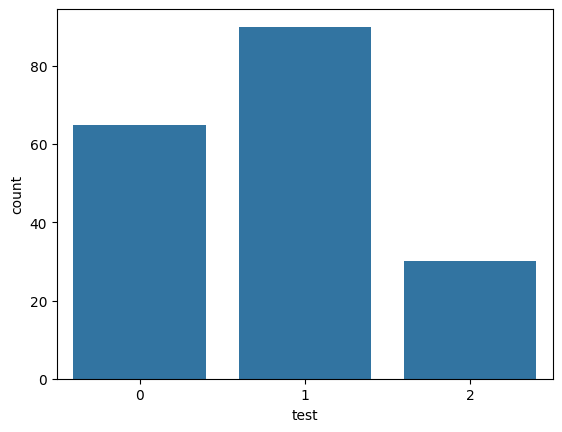

In [20]:
sns.countplot(data=result, x='test')

<Axes: xlabel='test', ylabel='count'>

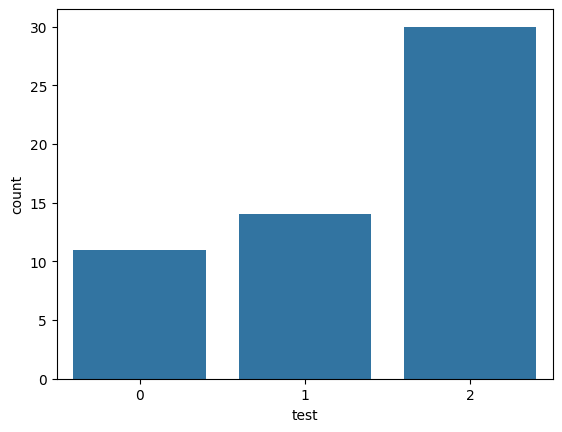

In [21]:
err = result[result['error'] == 1]
sns.countplot(data=err, x='test')

<Axes: xlabel='predict', ylabel='count'>

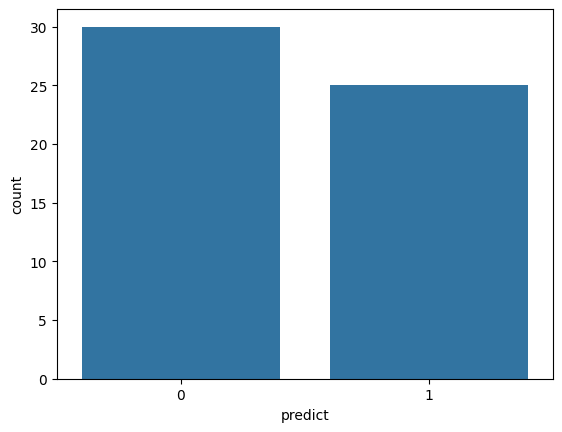

In [22]:
sns.countplot(data=err, x='predict')

В основном все ошибки при "ничьей" и мы видим, что редко предиктится ничья

In [23]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.35 and np.argmax(prob) == 2:
        predict.append(np.argmax(prob))
        indx.append(id)

    if max(prob) > 0.45 and np.argmax(prob) in [0, 1]:
        predict.append(np.argmax(prob))
        indx.append(id)
    

    
new_test = np.take(tests, indx)
print(len(tests), len(new_test))

380 268


In [24]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
result
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.5683940154049523
accuracy: 0.5447761194029851


<Axes: xlabel='test', ylabel='count'>

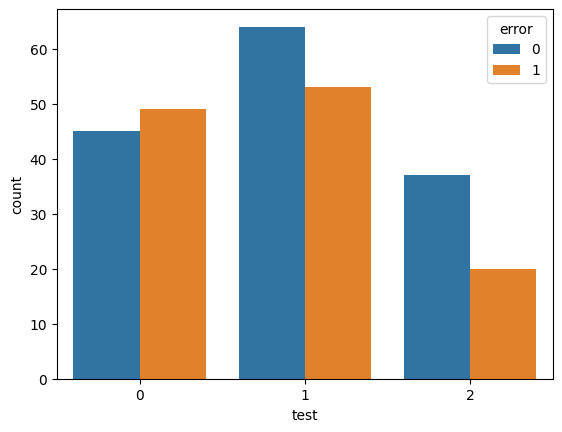

In [25]:
sns.countplot(data=result, x='test', hue='error')

<Axes: xlabel='predict', ylabel='count'>

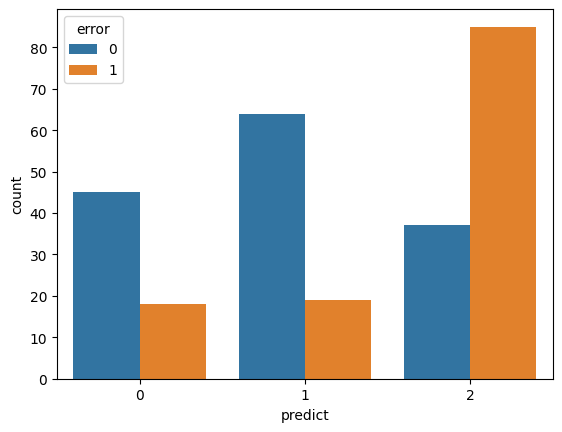

In [26]:
sns.countplot(data=result, x='predict', hue='error')

<Axes: xlabel='test', ylabel='count'>

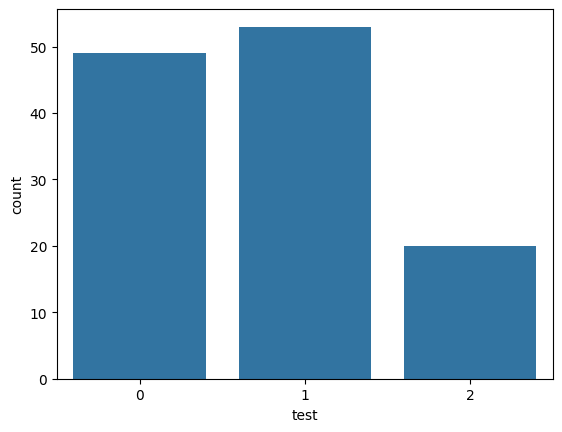

In [27]:
err = result[result['error'] == 1]
sns.countplot(data=err, x='test')

<Axes: xlabel='predict', ylabel='count'>

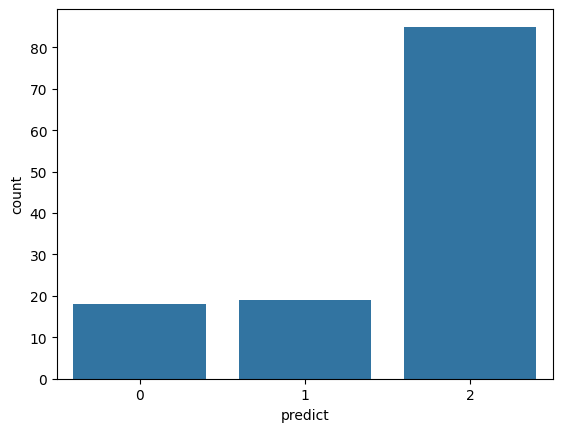

In [28]:
sns.countplot(data=err, x='predict')

## Cнижение размерности

In [29]:
df_pca = df.copy()

In [30]:
df_pca.fillna(0, inplace=True)

In [31]:
num_cols = list(set(df_pca.columns.tolist()) - set(cat_cols))

In [32]:
def pca_pipeline(df, y, cat_cols, num_cols, n_components=50, pca=True):
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])

    categorical_transformer = Pipeline(steps=[
        ('target_encoding', TargetEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])

    if pca:
        pca = PCA(n_components=n_components, random_state=42)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca)])

    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    X_processed = pipeline.fit_transform(df, y)

    return X_processed, pipeline

In [33]:
preds = []
tests = []
proba = []

for train_index, test_index in tscv.split(df_pca, y):
    y_train = y.iloc[train_index]
    X_train, processed = pca_pipeline(df_pca.iloc[train_index], y_train, cat_cols, num_cols)    

    X_test = processed.transform(df_pca.iloc[test_index])
    y_test = y.iloc[test_index]

    class_counts = np.bincount(y_train) #количество экземпляров каждого класса
    total_samples = np.sum(class_counts) #общее количество экземпляров
    class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
    
    model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)
    pred = model.predict(X_test)
    proba.extend(model.predict_proba(X_test))
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())
    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.6857142857142857
f1 score weighted: 0.47819548872180445
f1 score weighted: 0.6078947368421053
f1 score weighted: 0.43636363636363634
f1 score weighted: 0.7166666666666667
f1 score weighted: 0.4727272727272728
f1 score weighted: 0.5
f1 score weighted: 0.42661064425770306
f1 score weighted: 0.4188034188034188
f1 score weighted: 0.525
f1 score weighted: 0.7277511961722488
f1 score weighted: 0.5515873015873016
f1 score weighted: 0.5848484848484847
f1 score weighted: 0.5
f1 score weighted: 0.45584415584415583
f1 score weighted: 0.42833333333333334
f1 score weighted: 0.54
f1 score weighted: 0.4833333333333333
f1 score weighted: 0.6640522875816994


In [34]:
print('f1 score weighted:', f1_score(tests, preds, average='weighted'))

f1 score weighted: 0.538598712265739


In [35]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.4 and np.argmax(prob) == 2:
        predict.append(np.argmax(prob))
        indx.append(id)

    elif max(prob) > 0.45 and np.argmax(prob) in [0, 1]:
        predict.append(np.argmax(prob))
        indx.append(id) 

new_test = np.take(tests, indx)
print(len(tests), len(new_test))

380 77


In [36]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
result
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.7626728951498121
accuracy: 0.7922077922077922


In [37]:
best_n_pca, best_f1_pca = 0, 0
for n in tqdm(range(50, 650, 50)): #количество компонент
    preds = []
    tests = []
    proba = []    

    for train_index, test_index in tscv.split(df_pca, y):
        y_train = y.iloc[train_index]
        X_train, processed = pca_pipeline(df_pca.iloc[train_index], y_train, cat_cols, num_cols, n_components=n)    

        X_test = processed.transform(df_pca.iloc[test_index])
        y_test = y.iloc[test_index]

        class_counts = np.bincount(y_train) #количество экземпляров каждого класса
        total_samples = np.sum(class_counts) #общее количество экземпляров
        class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
        
        model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)
        pred = model.predict(X_test)
        proba.extend(model.predict_proba(X_test))
        preds.extend(pred.reshape(-1).tolist())
        tests.extend(y_test.tolist())

        
    predict, indx = [], []
    for id, prob in enumerate(proba):
        if max(prob) > 0.4 and np.argmax(prob) == 2:
            predict.append(np.argmax(prob))
            indx.append(id)

        elif max(prob) > 0.45 and np.argmax(prob) in [0, 1]:
            predict.append(np.argmax(prob))
            indx.append(id) 

    new_test = np.take(tests, indx)
    f1 = f1_score(new_test, predict, average='weighted')
    
    if f1 > best_f1_pca:
        best_f1_pca = f1
        best_n_pca = n   

    print(f'f1_score: {f1}\naccuracy: {accuracy_score(new_test, predict)}')
    print(f'best_n: {best_n_pca}, best_f1: {best_f1_pca}')

  8%|▊         | 1/12 [01:16<14:05, 76.91s/it]

f1_score: 0.7626728951498121
accuracy: 0.7922077922077922
best_n: 50, best_f1: 0.7626728951498121


 17%|█▋        | 2/12 [02:56<15:04, 90.45s/it]

f1_score: 0.7428415954726016
accuracy: 0.782608695652174
best_n: 50, best_f1: 0.7626728951498121


 25%|██▌       | 3/12 [04:35<14:06, 94.07s/it]

f1_score: 0.7471334971334972
accuracy: 0.7837837837837838
best_n: 50, best_f1: 0.7626728951498121


 33%|███▎      | 4/12 [06:25<13:23, 100.48s/it]

f1_score: 0.7409958462590043
accuracy: 0.7763157894736842
best_n: 50, best_f1: 0.7626728951498121


 42%|████▏     | 5/12 [08:31<12:48, 109.74s/it]

f1_score: 0.7364752059901989
accuracy: 0.7761194029850746
best_n: 50, best_f1: 0.7626728951498121


 50%|█████     | 6/12 [10:34<11:24, 114.05s/it]

f1_score: 0.7477661227661228
accuracy: 0.7878787878787878
best_n: 50, best_f1: 0.7626728951498121


 58%|█████▊    | 7/12 [12:54<10:13, 122.70s/it]

f1_score: 0.7477661227661228
accuracy: 0.7878787878787878
best_n: 50, best_f1: 0.7626728951498121


 67%|██████▋   | 8/12 [15:17<08:36, 129.03s/it]

f1_score: 0.7477661227661228
accuracy: 0.7878787878787878
best_n: 50, best_f1: 0.7626728951498121


 75%|███████▌  | 9/12 [17:43<06:43, 134.36s/it]

f1_score: 0.7441970310391363
accuracy: 0.7846153846153846
best_n: 50, best_f1: 0.7626728951498121


 83%|████████▎ | 10/12 [20:10<04:36, 138.45s/it]

f1_score: 0.7400465695920242
accuracy: 0.7727272727272727
best_n: 50, best_f1: 0.7626728951498121


 92%|█████████▏| 11/12 [22:52<02:25, 145.65s/it]

f1_score: 0.7415123456790124
accuracy: 0.7777777777777778
best_n: 50, best_f1: 0.7626728951498121


100%|██████████| 12/12 [25:36<00:00, 128.02s/it]

f1_score: 0.744727469081318
accuracy: 0.782608695652174
best_n: 50, best_f1: 0.7626728951498121


In [38]:
print(best_n_pca, best_f1_pca)

50 0.7626728951498121


Попробуем отобрать признаки с помощью дерева

In [39]:
f1, best_features = 0, 0
for n in tqdm(range(50, 650, 50)): #количество признаков с каждого фолда    
    features = []

    X, _ = pca_pipeline(df_pca, y, cat_cols, num_cols, pca=False)
    X = pd.DataFrame(X, columns=df_pca.columns)
    rf = RandomForestClassifier()

    selector = SelectFromModel(rf, max_features=n)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    features.extend(selected_features)
        
    df_new = df_pca.loc[:, features]

    preds = []
    tests = []
    proba = []
    cat_feat = [feat for feat in features if feat in cat_cols]

    for train_index, test_index in tscv.split(df_new, y):
        y_train = y.iloc[train_index]
        X_train = df_new.iloc[train_index]

        X_test = df_new.iloc[test_index]
        y_test = y.iloc[test_index]

        class_counts = np.bincount(y_train) #количество экземпляров каждого класса
        total_samples = np.sum(class_counts) #общее количество экземпляров
        class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
        
        model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_feat, plot=False)
        pred = model.predict(X_test)
        proba.extend(model.predict_proba(X_test))
        preds.extend(pred.reshape(-1).tolist())
        tests.extend(y_test.tolist())

    predict, indx = [], []
    for id, prob in enumerate(proba):
        if max(prob) > 0.4 and np.argmax(prob) == 2:
            predict.append(np.argmax(prob))
            indx.append(id)

        elif max(prob) > 0.45 and np.argmax(prob) in [0, 1]:
            predict.append(np.argmax(prob))
            indx.append(id) 

    new_test = np.take(tests, indx)

    print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

    if f1 < f1_score(new_test, predict, average="weighted"):
        f1 = f1_score(new_test, predict, average="weighted")
        best_features = features        

  8%|▊         | 1/12 [01:01<11:21, 61.94s/it]

f1_score: 0.6976534461290558
accuracy: 0.7430555555555556


 17%|█▋        | 2/12 [02:02<10:13, 61.38s/it]

f1_score: 0.7284370801612181
accuracy: 0.7727272727272727


 25%|██▌       | 3/12 [03:04<09:13, 61.51s/it]

f1_score: 0.7065671972932497
accuracy: 0.7516778523489933


 33%|███▎      | 4/12 [04:06<08:14, 61.81s/it]

f1_score: 0.69268524403529
accuracy: 0.7350993377483444


 42%|████▏     | 5/12 [05:08<07:13, 61.87s/it]

f1_score: 0.696727308620041
accuracy: 0.7419354838709677


 50%|█████     | 6/12 [06:08<06:07, 61.29s/it]

f1_score: 0.7014824951533813
accuracy: 0.75


 58%|█████▊    | 7/12 [07:09<05:05, 61.01s/it]

f1_score: 0.6983052608789782
accuracy: 0.7449664429530202


 67%|██████▋   | 8/12 [08:09<04:03, 60.84s/it]

f1_score: 0.6945875730677636
accuracy: 0.7449664429530202


 75%|███████▌  | 9/12 [09:13<03:05, 61.77s/it]

f1_score: 0.6977880794701987
accuracy: 0.7417218543046358


 83%|████████▎ | 10/12 [10:18<02:05, 62.55s/it]

f1_score: 0.7009474930911962
accuracy: 0.7449664429530202


 92%|█████████▏| 11/12 [11:21<01:02, 62.77s/it]

f1_score: 0.7140880600995733
accuracy: 0.7567567567567568


100%|██████████| 12/12 [12:25<00:00, 62.13s/it]

f1_score: 0.6866691866691866
accuracy: 0.7364864864864865
